In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
df = pd.read_csv("exchange_rate.csv")
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], dayfirst=True)
df.columns = ["Date", "USD_AUD"]
df.set_index("Date", inplace=True)
df.head()

C:\Users\RITHIKA\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,USD_AUD
Date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


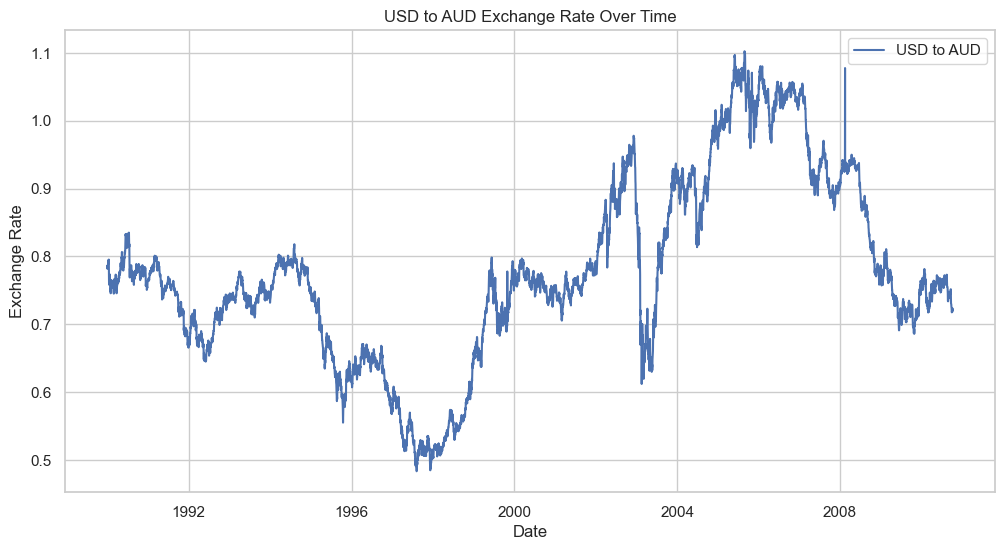

In [45]:
plt.plot(df.index, df["USD_AUD"], label="USD to AUD")
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()


In [46]:
df.isnull().sum()

USD_AUD    0
dtype: int64

In [48]:
adf_result = adfuller(df["USD_AUD"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


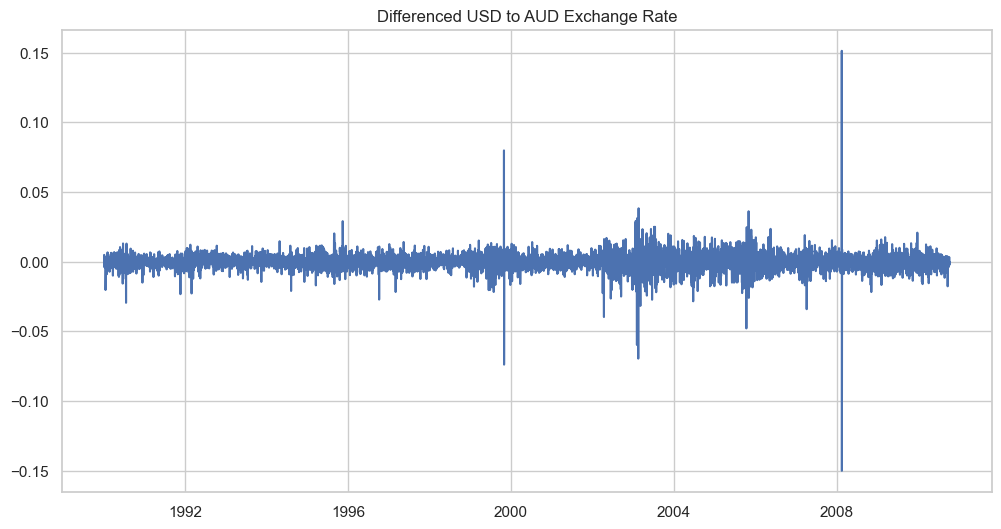

In [49]:
df_diff = df["USD_AUD"].diff().dropna()
plt.plot(df_diff)
plt.title("Differenced USD to AUD Exchange Rate")
plt.show()

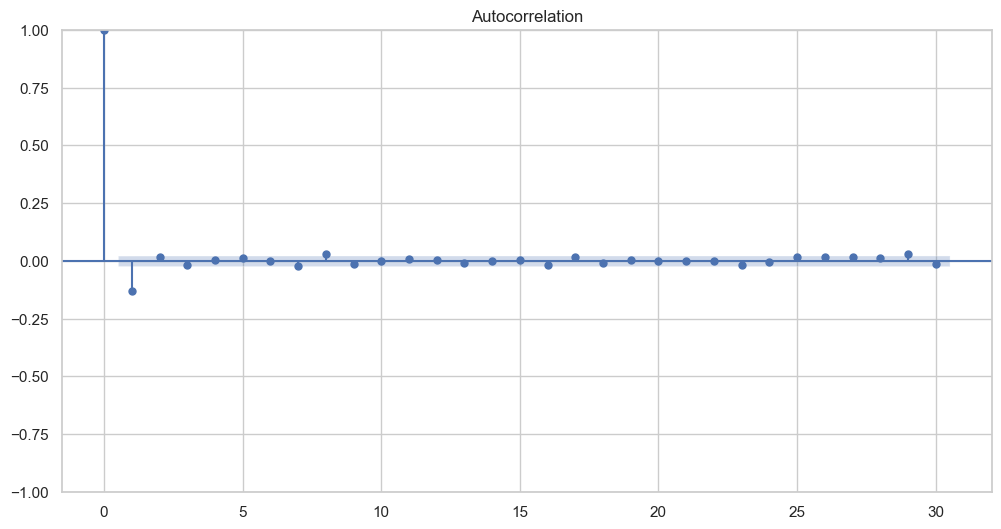

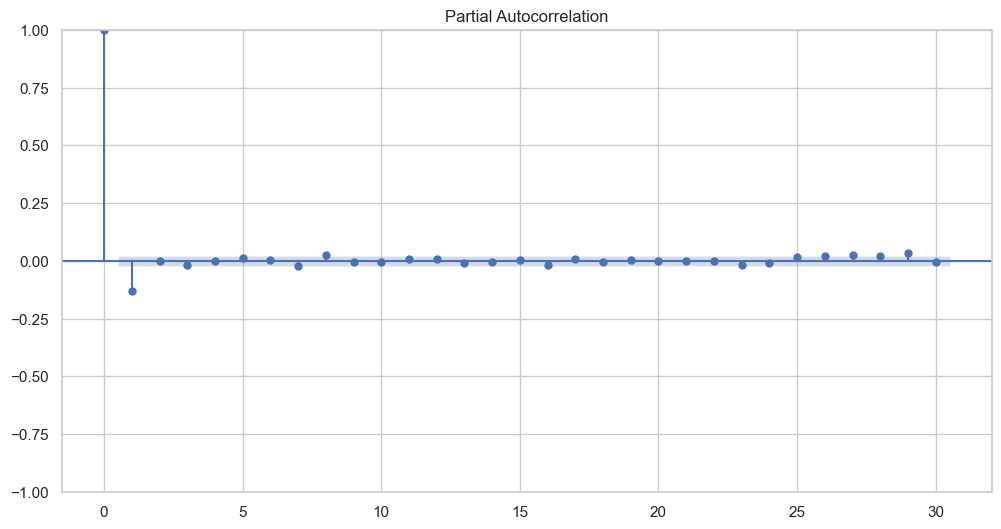

In [50]:
plot_acf(df_diff, lags=30)
plt.show()

plot_pacf(df_diff, lags=30)
plt.show()


In [55]:
train_size = int(len(df) * 0.8)
train, test = df["USD_AUD"][:train_size], df["USD_AUD"][train_size:]


In [56]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

print(arima_result.summary())


C:\Users\RITHIKA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\RITHIKA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\RITHIKA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Wed, 28 Jan 2026   AIC                         -45432.092
Time:                        10:56:53   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

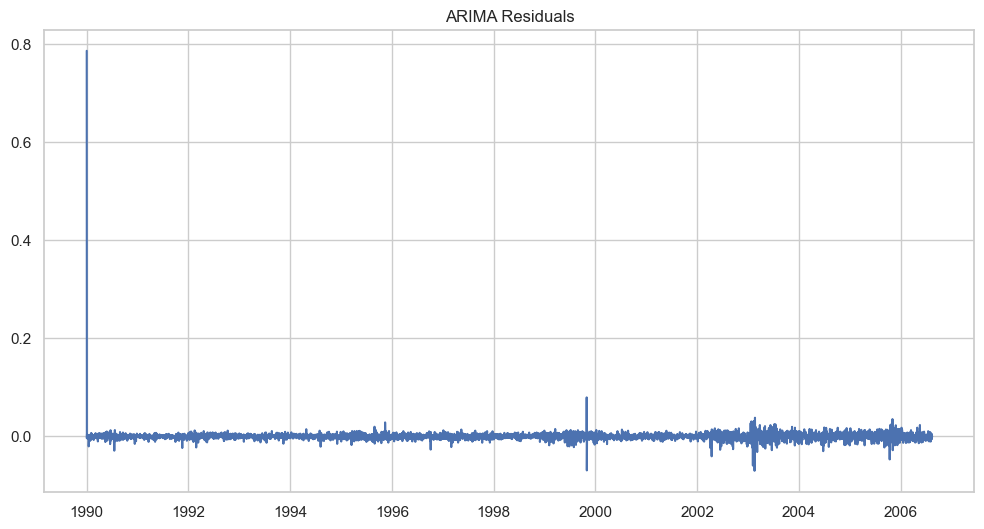

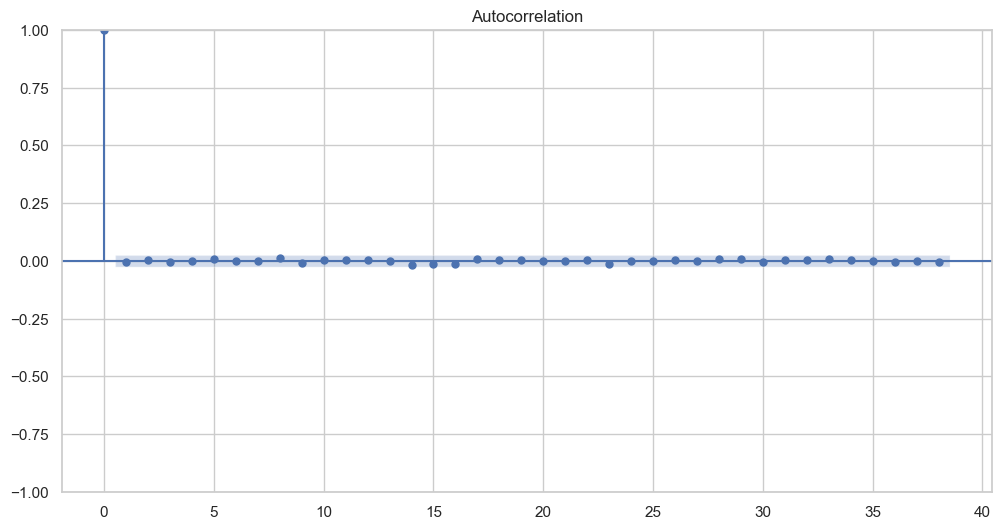

In [57]:
residuals = arima_result.resid

plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.show()

plot_acf(residuals)
plt.show()


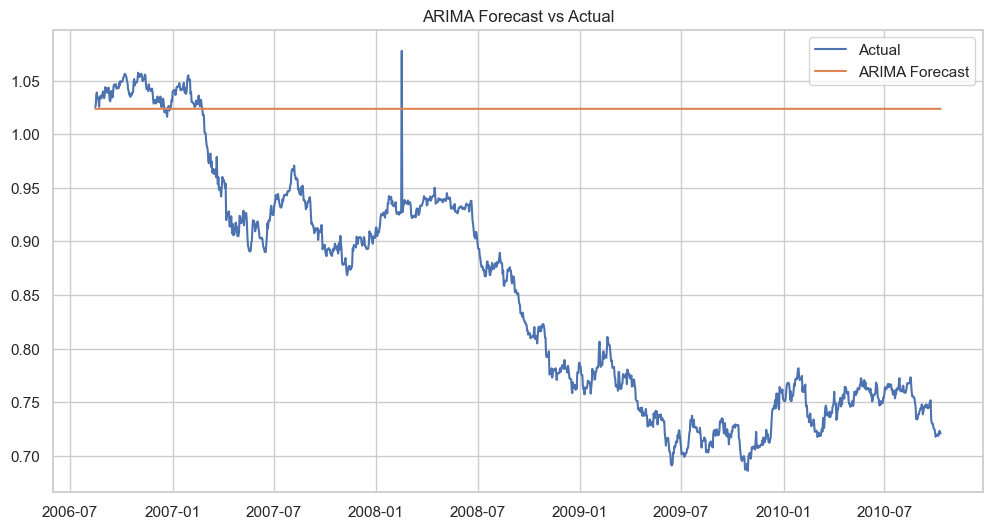

In [58]:
arima_forecast = arima_result.forecast(steps=len(test))

plt.plot(test.index, test, label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()



C:\Users\RITHIKA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


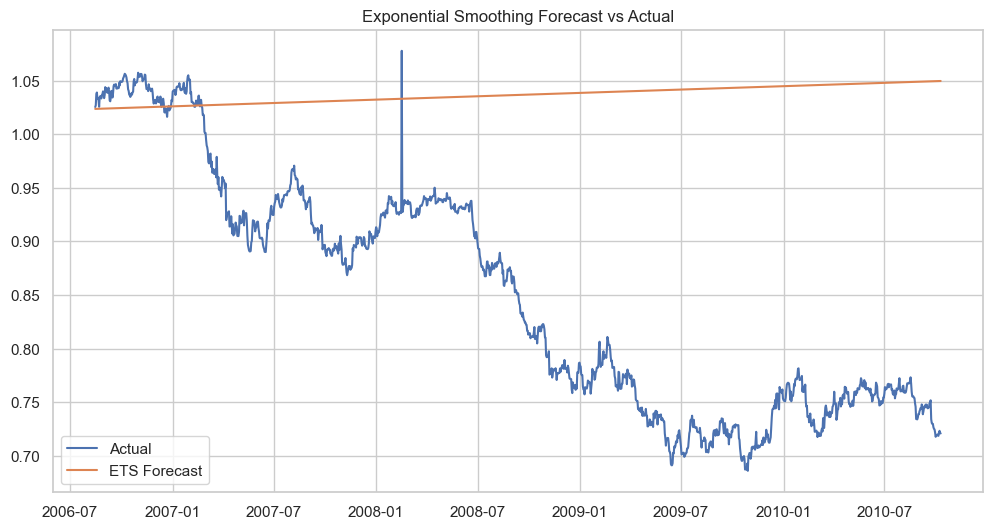

In [60]:
ets_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None
).fit()

ets_forecast = ets_model.forecast(len(test))

plt.plot(test.index, test, label="Actual")
plt.plot(test.index, ets_forecast, label="ETS Forecast")
plt.title("Exponential Smoothing Forecast vs Actual")
plt.legend()
plt.show()


In [61]:
def evaluate_model(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape

In [62]:
arima_mae, arima_rmse, arima_mape = evaluate_model(test, arima_forecast)
ets_mae, ets_rmse, ets_mape = evaluate_model(test, ets_forecast)

results = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [arima_mae, ets_mae],
    "RMSE": [arima_rmse, ets_rmse],
    "MAPE (%)": [arima_mape, ets_mape]
})

results


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.177710,0.205437,22.797966
1,Exponential Smoothing,0.190273,0.220085,24.412696
